In [2]:
import src.graphs as graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.main as main
import src.config as config
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = [14,3]
sns.set(style="whitegrid")

## Graphs

In [5]:
gr = pd.DataFrame(
    [ graphs.Petersen, graphs.Twenty, graphs.HoffmanSingleton, graphs.D4K4 ],
    columns=['graph'],
    index=['petersen','twenty','hoffmanSingleton','d4k4']
)
gr['order'] = gr['graph'].map(lambda x: x.vcount())
gr['diameter'] = gr['graph'].map(lambda x: x.diameter())
gr['degree'] = gr['graph'].map(lambda x: x.maxdegree() // 2)
gr['size'] = gr['graph'].map(lambda x: x.ecount())
gr['girth'] = gr['graph'].map(lambda x: x.girth())
gr['radius'] = gr['graph'].map(lambda x: x.radius())
gr['avg_path_length'] = gr['graph'].map(lambda x: x.average_path_length())
gr['degree * diameter'] = gr['degree'] * gr['diameter']
# gr['independence'] = gr['graph'].map(lambda x: x.alpha())
# gr['cyclicity'] = gr['graph'].map(lambda x: x.cyclicity())
gr

,graph,order,diameter,degree,size,girth,radius,avg_path_length,degree * diameter
petersen,IGRAPH D--- 10 40 --\n+ edges:\n 0 -> 0 2 3...,10,2,3,40,5,2,1.6667,6
twenty,IGRAPH D--- 20 80 --\n+ edges:\n 0 -> 0 5 10...,20,3,3,80,5,3,2.3684,9
hoffmanSingleton,IGRAPH D--- 50 400 --\n+ edges:\n 0 -> 0 2 ...,50,2,7,400,5,2,1.8571,14
d4k4,IGRAPH D--- 98 490 --\n+ edges:\n 0 -> 0 31 4...,98,4,4,490,6,4,3.2754,16


## Run Simulation

In [12]:
results = {}
summary = pd.DataFrame()
for g in gr.index:
    print(f'Running simulation for {g}')
    graph = gr.loc[g,'graph']
    conf = config.Config()
    conf.GRAPH = graph

    # run simulation
    cw = main.main(conf, 1000000)

    # process results
    # exlude the first 1000 block heights
    r = main.get_data(cw).query('height > 1000')
    results[g] = r

results = pd.concat(results, names=['graph'])

Running simulation for petersen
[100000.0][MONITOR] 80.0 % blocked
[200000.0][MONITOR] 50.0 % blocked
[300000.0][MONITOR] 40.0 % blocked
[400000.0][MONITOR] 50.0 % blocked
[500000.0][MONITOR] 60.0 % blocked
[600000.0][MONITOR] 70.0 % blocked
[700000.0][MONITOR] 80.0 % blocked
[800000.0][MONITOR] 60.0 % blocked
[900000.0][MONITOR] 50.0 % blocked
Running simulation for twenty
[100000.0][MONITOR] 80.0 % blocked
[200000.0][MONITOR] 65.0 % blocked
[300000.0][MONITOR] 75.0 % blocked
[400000.0][MONITOR] 55.0 % blocked
[500000.0][MONITOR] 65.0 % blocked
[600000.0][MONITOR] 80.0 % blocked
[700000.0][MONITOR] 65.0 % blocked
[800000.0][MONITOR] 55.0 % blocked
[900000.0][MONITOR] 55.0 % blocked
Running simulation for hoffmanSingleton
[100000.0][MONITOR] 42.0 % blocked
[200000.0][MONITOR] 66.0 % blocked
[300000.0][MONITOR] 68.0 % blocked
[400000.0][MONITOR] 68.0 % blocked
[500000.0][MONITOR] 68.0 % blocked
[600000.0][MONITOR] 92.0 % blocked
[700000.0][MONITOR] 86.0 % blocked
[800000.0][MONITOR] 58.

In [13]:
results.reset_index('height').groupby('graph')['height'].max()

graph
d4k4                33325
hoffmanSingleton    33278
petersen            33259
twenty              33297
Name: height, dtype: int64

In [14]:
means = results.groupby('graph').mean().join(gr[['order','diameter','degree','size','girth']])
means['percent blocked'] = 100 * means['blocked times'] / means['cycle times']
means['minable chains'] = means['hash power factors'] * means['order']
means

,cycle times,blocked times,targets,new block times,mine times,hash power factors,order,diameter,degree,size,girth,percent blocked,minable chains
graph,,,,,,,,,,,,,
d4k4,30.0037,20.5351,29.2492,0.0100,9.4585,0.3236,98,4,4,490,6,68.4420,31.7114
hoffmanSingleton,30.0247,21.8370,24.1524,0.0100,8.1777,0.3383,50,2,7,400,5,72.7303,16.9154
petersen,30.0462,18.2243,25.4176,0.0100,11.8119,0.4646,10,2,3,40,5,60.6542,4.6460
twenty,30.0250,18.8838,27.7409,0.0100,11.1311,0.4022,20,3,3,80,5,62.8938,8.0441


In [19]:
means['block time percent'] = 100 * means['blocked times'] / means['cycle times']
means['blocked chains percent'] = 100 - 100 * means['minable chains'] / means['order']
print(means[['block time percent','blocked chains percent']].to_markdown())


| graph            |   block time percent |   blocked chains percent |
|:-----------------|---------------------:|-------------------------:|
| d4k4             |              68.442  |                  67.6414 |
| hoffmanSingleton |              72.7303 |                  66.1691 |
| petersen         |              60.6542 |                  53.5404 |
| twenty           |              62.8938 |                  59.7793 |


In this simulation a large target means a high difficulty. In a chainweb where chains are blocked a lot, individual chains, when minable receive a larger portion of the hash power, which can result in larger target values.

While the `hash power factor`, and thus the portion of the minable chains, decreases for larger graphs, the absolute number of minable chains increases. We can assume that the number of chains will grow faster than the number distinct mining nodes. The absolute values is thus of greater importance for the efficiency of mainnet.

We note that the degree seems to have a similarly large impact on the number of blocked chains as the size of the graph.

A cause of concern is the decrease is mining time, which is related to the decrease of the hash power factor. This may increase the likelyhood of races and thus orphans. It is an open question whether the positive effect of a larger absolute number of mineable chains can outweight the negative effect of the decreased mining time. This simulation does not model races and orphan mining. Therefore it can not answer that question.

We notice that the product of `hash power factor` and `target` is about the same as the `mine time`:

In [11]:
pd.DataFrame({'factors * targets': means['hash power factors'] * means['targets'], 'mine times': means['mine times']})

,factors * targets,mine times
graph,,
d4k4,9.4646,9.4585
hoffmanSingleton,8.1710,8.1777
petersen,11.8089,11.8119
twenty,11.1576,11.1311


We also notices that `cycle time` equals the sum of `blocked time` and `mine time`:

In [12]:
pd.DataFrame({'blocked times + mine times + new block times': means['blocked times'] + means['mine times'] + means['new block times'], 'cycle times': means['cycle times']})

,blocked times + mine times + new block times,cycle times
graph,,
d4k4,30.0037,30.0037
hoffmanSingleton,30.0247,30.0247
petersen,30.0462,30.0462
twenty,30.0250,30.0250


In [13]:
stds = results.groupby('graph').std().join(gr[['order','diameter','degree','size']])
stds


,cycle times,blocked times,targets,new block times,mine times,hash power factors,order,diameter,degree,size
graph,,,,,,,,,,
d4k4,19.9272,17.6272,0.3498,0.0045,9.9079,0.0708,98,4,4,490
hoffmanSingleton,18.9077,16.9157,0.7612,0.0045,9.3818,0.1350,50,2,7,400
petersen,22.4014,18.9662,1.0615,0.0045,13.1025,0.1579,10,2,3,40
twenty,21.6211,18.6302,0.7398,0.0045,12.0606,0.1171,20,3,3,80


## Blocked Time

In [14]:
results

cycle times  blocked times  targets  new block times  \
graph    height chain                                                         
petersen 1001   0          54.7469        43.7631  24.9185           0.0080   
                1           1.0873         0.6852  24.9190           0.0072   
                2           1.1417         0.4270  24.9382           0.0086   
                3          65.7029         9.5911  24.9033           0.0086   
                4          72.5111        55.2351  24.9122           0.0169   
...                            ...            ...      ...              ...   
d4k4     33325  71         26.5055        19.4991  29.6860           0.0163   
                72         28.4837        27.8036  29.7130           0.0210   
                78         18.6314         7.6840  29.7890           0.0100   
                86         15.9749        11.6960  29.6763           0.0107   
                89         24.8914        22.4156  29.6222           0.0038   

                       mine times  hash power factors  
graph    height chain                                  
petersen 1001   0         10.9758              0.4000  
                1          0.3950              0.5000  
                2          0.7061              0.2000  
                3         56.1033              0.5000  
                4         17.2592              0.3000  
...                           ...                 ...  
d4k4     33325  71         6.9902              0.4694  
                72         0.6591              0.3878  
                78        10.9374              0.3265  
                86         4.2681              0.4082  
                89         2.4720              0.4082  

[5750138 rows x 6 columns]

(0.0, 100.0)

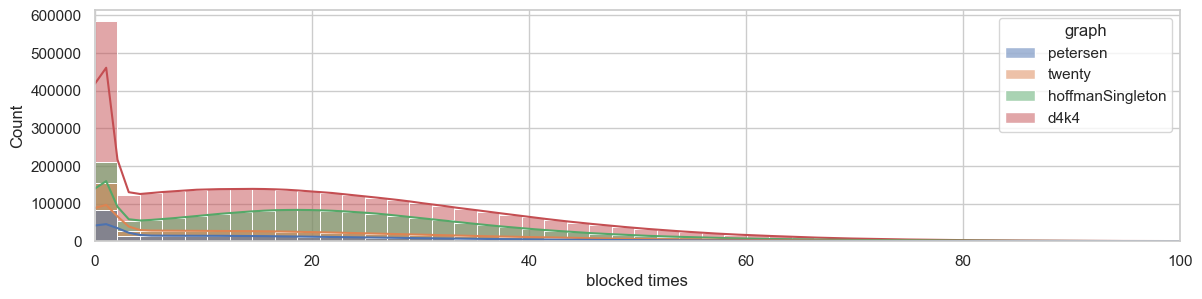

In [15]:
ax = sns.histplot(data = results.reset_index(), x='blocked times', bins = 100, hue='graph', kde=True)
ax.set_xlim(0, 100)
#ax.set_ylim(0, 20000)

# Mine Time

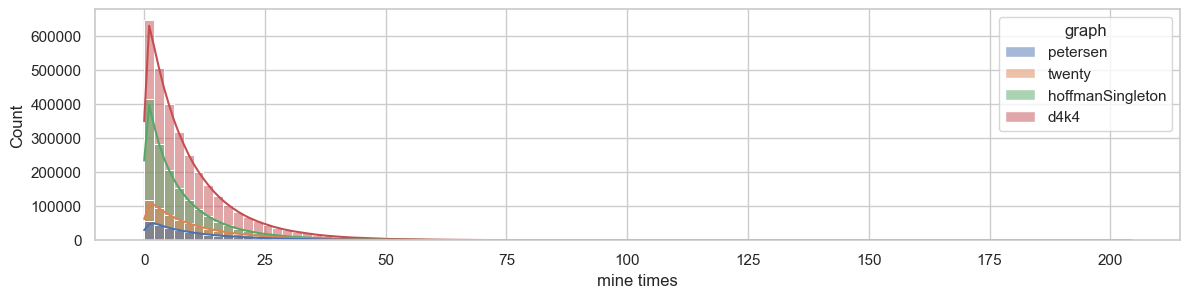

In [18]:
ax = sns.histplot(data = results.reset_index(), x='mine times', bins = 100, hue='graph', kde=True, alpha=0.5)
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 40000)


## Hash Power Factors

This measures how many chains are mined concurrently.

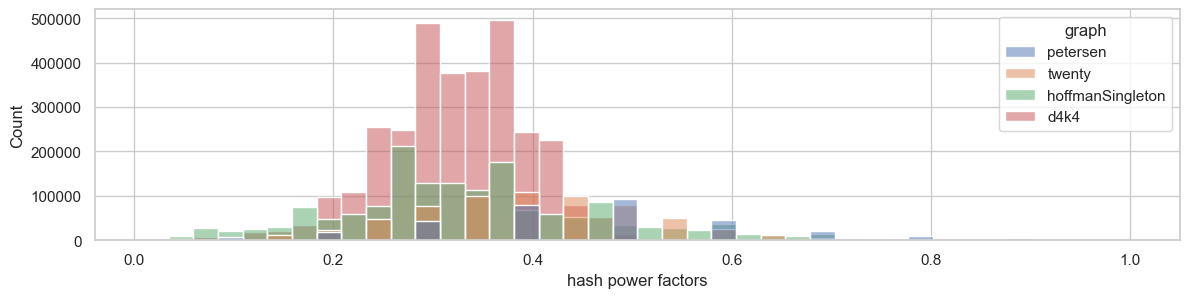

In [19]:
ax = sns.histplot(data = results.reset_index(), x='hash power factors', bins = 40, hue='graph', alpha=0.5)

## Targets

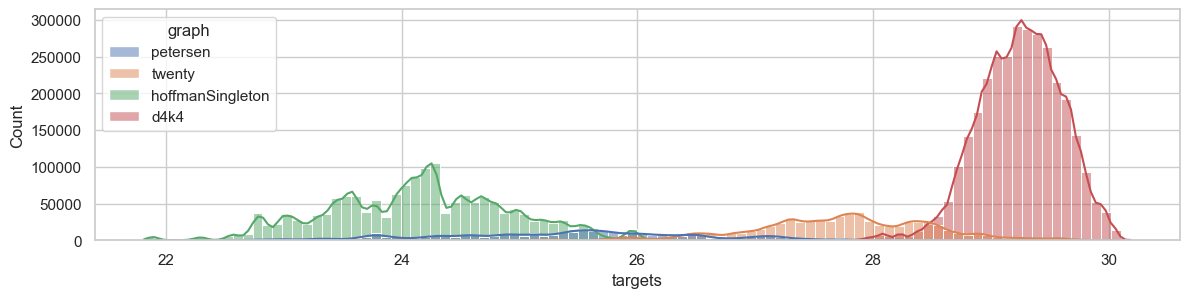

In [20]:
ax = sns.histplot(data = results.reset_index(), x='targets', bins = 100, hue='graph', kde=True)

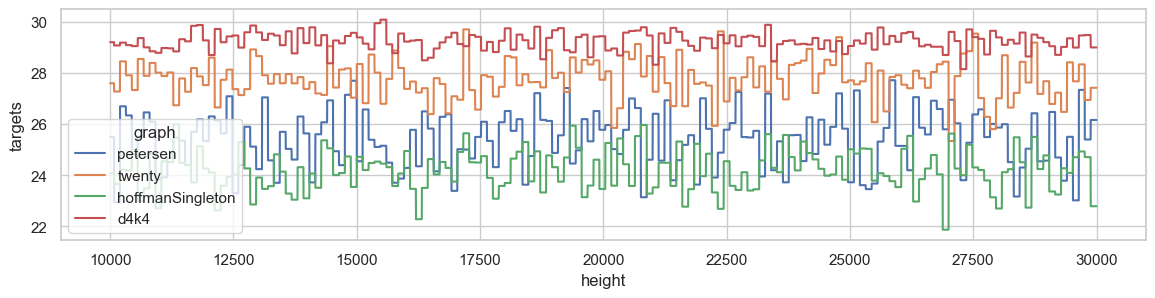

In [21]:
# ax = sns.lineplot(data = df.query('height > 1000'), x = 'height', y = 'targets', hue='chain')
ax = sns.lineplot(data = results.query('chain == 0 and height > 10000 and height < 30000').reset_index(), x='height', y = 'targets', hue='graph')

# Discussion

After a new block is mined on a chain there is a higher chance that the chain is blocked. This means that most likely there a considerable
overlap of the time that is chain is blocked and the time that blocks propgate. This reduces the time spent on orphan mining futher.

TODO: measure this overlap!
